# Introdução

Descrição da atividade.

Imagine agora, que você vai atuar como Expert em Data Analytics em uma empresa que exporta vinhos do Brasil para o mundo todo.

Sua área é recém-criada dentro da empresa, e você será responsável pelos relatórios iniciais a serem apresentados em uma reunião de investidores e acionistas, explicando a quantidade de vinhos exportados e os fatores externos que podem vir a surgir e que interferem nas análises:

- 	Dados climáticos.
- 	Dados demográficos.
- 	Dados econômicos.
- 	Dados de avaliações de vinhos.
  
O Head de Dados pediu para que você construísse uma tabela contendo as seguintes informações:
-   País de origem (Brasil).
- 	País de destino.
- 	Quantidade em litros de vinho exportado (utilize: 1KG =1L).
- 	Valor em US$.

Os dados que lhe forneceram são de uma vinícola parceira, e podem ser encontrados  [aqui](http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_01).
Tomando como referência o [relatório](https://ainfo.cnptia.embrapa.br/digital/bitstream/item/215377/1/COMUNICADO-TECNICO-214-Publica-602-versao-2020-08-14.pdf), sabemos que os valores exportados constantes das bases de dados estão em US$ 1.000,00 (FOB).

Com o intuito de confirmar tal informação, ainda extraímos os dados diretamente da plataforma [Comexstat](http://comexstat.mdic.gov.br/pt/geral/97910) de responsabilidade do Ministério da Indústria, Comércio Exterior e Serviços (MDIC). Nesta caso, os vinhos de mesa correspondem ao produto de Código CUCI 11217 - "Vinhos de uvas frescas (exceto vinho espumante); mostos de uvas cuja fermentação tenha sido impedida ou interrompida por adição de álcool".

Ao compararmos os dados da Comexstat com os dados da Vitibrasil, vemos que o valor exportado está expresso em US$ 1.000,00 (FOB).


https://balanca.economia.gov.br/balanca/manual/Manual.pdf

https://ourworldindata.org

https://data.worldbank.org

 Classificação Uniforme para o Comércio Internacional - CUCI, também conhecida
como Standard International Trade Classification - SITC é uma classificação de produto da ONU
usada para estatísticas de comércio exterior (valores de exportação e importação e volumes de
mercadorias), permitindo comparações internacionais de mercadorias e produtos
manufaturados.


O valor FOB indica o preço da mercadoria em dólares americanos sob o Incoterm FOB
(Free on Board), modalidade na qual o vendedor é responsável por embarcar a mercadoria
enquanto o comprador assume o pagamento do frete, seguros e demais custos pós embarque.
Nesse caso, o valor informado da mercadoria expressa o valor exclusivamente da mercadoria.


Medida que expressa o peso líquido da mercadoria. Mesmo produtos com quantidades
estatísticas diferentes do quilograma também possuem disponível a medida em quilograma,
referindo-se ao peso líquido da mercadoria, ou seja, mercadoria desconsiderando embalagens,
caixas ou quaisquer outros adicionais de transporte. Vale relembrar que essa informação, bem
como as demais informadas nas operações de comércio exterior, é de livre preenchimento e de
responsabilidade exclusiva dos operadores de comércio exterior.


- opções de ferramentas:
  - https://ipyvizzu-story.vizzuhq.com/latest/
  - http://gsap.com/

# Análise de dados

O primeiro passo para a análise de dados é a importação das bibliotecas necessárias. Neste trabalho foi utilizada a biblioteca _polars_ para manipulação de dados e a biblioteca _plotly_ para a confecção de gráficos. 

In [1]:
# importa as bibliotecas e carrega os dados
import plotly.express as px
import polars as pl
from itables import show
import plotly.io as pio
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

plt.style.use("ggplot")


warnings.filterwarnings("ignore")

ImportError: DLL load failed while importing _path: Não foi possível encontrar o módulo especificado.

In [ ]:
# estilização de figuras e tabelas
fig_w, fig_h = 800, 600
pio.templates.default = "plotly_white"

Primeiramente analisaremos a série dos dados de quantidade e valor exportado a partir dos dados  extraídos diretamente do Comexstat. Tal escolha decorreu do fato de que, havendo a fonte primária, é preferível utilizar os dados dela proveniente com vistas a garantir a fidedignidade dos dados. Outro ponto que nos fez optar pelo uso dos dados do Comexstat é que assim pudemos ter acesso aos dados também em base mensal, os quais são úteis para análises mais completas.

In [ ]:
# carrega os dados de importação de vinhos (dados da página indica)
exp_vinho_viti = (
    pl.read_csv("../data/ExpVinho.csv", separator=";")
    .rename({"País": "country"})
    .drop("Id")
)

exp_vinho_viti.filter(pl.col("country") == "Rússia")
# dados de quantidade exportada
# exp_vinho_qty = exp_vinho.select(
#     cs.by_name("country")
#     #| cs.by_name("iso_alpha")
#     #| cs.by_name("continent")
#     #| cs.ends_with("_0") & cs.starts_with("2")
# )
# exp_vinho_qty.columns = [
#     col.replace("_duplicated_0", "") for col in exp_vinho_qty.columns
# ]

# # dados de exportação em valor (US$)
# exp_vinho_val = exp_vinho.select(
#     cs.by_name("country")
#     #| cs.by_name("iso_alpha")
#     #| cs.by_name("continent")
#     | ~cs.ends_with("_0") & cs.starts_with("2")
# )

country,1970,1970_duplicated_0,1971,1971_duplicated_0,1972,1972_duplicated_0,1973,1973_duplicated_0,1974,1974_duplicated_0,1975,1975_duplicated_0,1976,1976_duplicated_0,1977,1977_duplicated_0,1978,1978_duplicated_0,1979,1979_duplicated_0,1980,1980_duplicated_0,1981,1981_duplicated_0,1982,1982_duplicated_0,1983,1983_duplicated_0,1984,1984_duplicated_0,1985,1985_duplicated_0,1986,1986_duplicated_0,1987,1987_duplicated_0,…,2004_duplicated_0,2005,2005_duplicated_0,2006,2006_duplicated_0,2007,2007_duplicated_0,2008,2008_duplicated_0,2009,2009_duplicated_0,2010,2010_duplicated_0,2011,2011_duplicated_0,2012,2012_duplicated_0,2013,2013_duplicated_0,2014,2014_duplicated_0,2015,2015_duplicated_0,2016,2016_duplicated_0,2017,2017_duplicated_0,2018,2018_duplicated_0,2019,2019_duplicated_0,2020,2020_duplicated_0,2021,2021_duplicated_0,2022,2022_duplicated_0
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Rússia""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,177600,71988,334200,164744,266400,173160,6207658,2352768,21912914,5732280,0,0,0,0,4528176,2103968,5893291,14795694,190656,61440,47664,18240,0,0,0,0,0,0,0,0,1463,8550,181931,312926,66046,118618


# Série Anual - extraída do Comexstat

In [ ]:
# carrega dados extraídos do sistema do MDIC na forma de
exp_vinho = (
    pl.read_csv("../data/EXP_VINHO_2000_2022_20231118_anual.csv", separator=";").rename(
        {
            "Ano": "year",
            "Países": "country",
            "Valor FOB (US$)": "value",
            "Quilograma Líquido": "quantity",
        }
    )
).drop(["Código CUCI Item", "Descrição CUCI Item"])


# carrega os dados com as colunas necessárias para posterior plotagem dos dados em mapa
df = px.data.gapminder()

geo_info = (
    df.groupby(["country", "iso_alpha"])
    .first()
    .reset_index()[["country", "iso_alpha", "continent"]]
)

# carrega os nomes dos países em inglês e em português para os países
countries_names = pl.read_csv("../data/countries_names.csv", truncate_ragged_lines=True)

# exp_vinho = pl.DataFrame.join(pl.from_dataframe(geo_info), exp_vinho, on="country")

In [ ]:
show(exp_vinho)

Os dados monetários desta série são anuais e estão em US$. Como a ideia é realizar a análise dos dados ao longo do tempo, é importante considerar os efeitos da inflação pois, US$ 1,00 em 2000 é diferente de US$ 1,00 em 2022. Ou seja, caso não se faça a correção pela inflação, haverá imprecisão nos valores apresentados. Ademais, ao se relacionar os valores de exportação com dados socioeconômicos, é importante que os dados estejam na mesma data de referência. Ainda que façamos tal ajuste, ainda resta dúvida quanto à data-base precisa, pois tal informação não foi encontrada em qualquer das fontes de dados. Neste sentido, assumimos que os valores da série são nominais, isto é, os valores são relativos ao ano corrente. Então todos eles foram reajustados para o ano de 2022. 
Para realizarmos o ajuste foi extraída a série de [CPI](https://www.bls.gov/cpi/) (_Consumer Price Index_) anual, que é o índice de inflação dos Estados Unidos. O gráfico abaixo demonstra que entre 2000 e 2022 houve um crescimento acumulado do índice na ordem de aproximadamente 52%. 

In [ ]:
cpi_us = pl.read_csv(
    "../data/cpi_brazil_us/cpi_series.csv",
    separator=";",
    dtypes={"year": pl.Int64, "cpi": pl.Float64},
)

px.line(
    cpi_us,
    x="year",
    y="cpi",
    title="CPI - índice de inflação dos Estados Unidos (anual)",
    width=fig_w,
    height=fig_h,
    labels={"year": "ano"},
)
# cpi_us

In [ ]:
# (cpi_us.filter(pl.col("year") == 2000)['cpi']-cpi_us.filter(pl.col("year") == 2001)['cpi'])/cpi_us.filter(pl.col("year") == 2001)['cpi']
cpi_us.select((pl.col("cpi").shift(-1) - pl.col("cpi")) / pl.col("cpi").shift(-1)).sum()

cpi
f64
0.521283


In [ ]:
infl_year = pl.Series(
    "infl_year", 1.0 / (cpi_us["cpi"] / cpi_us.filter(pl.col("year") == 2022)["cpi"])
)
cpi_us.insert_at_idx(2, infl_year)

year,cpi,infl_year
i64,f64,f64
2000,172.2,1.699506
2001,177.1,1.652484
2002,179.9,1.626765
2003,184.0,1.590516
2004,188.9,1.549259
2005,195.3,1.49849
2006,201.6,1.451662
2007,207.342,1.41146
2008,215.303,1.35927


In [ ]:
exp_vinho_corrected = exp_vinho.join(cpi_us, on="year").sort("year")
(
    exp_vinho_corrected.insert_at_idx(
        3,
        pl.Series(
            "value_corrected",
            exp_vinho_corrected["value"] * exp_vinho_corrected["infl_year"],
        ),
    )
).drop(["cpi", "infl_year"])

year,country,value,value_corrected,quantity
i64,str,i64,f64,i64
2000,"""Paraguai""",2394569,4.0696e6,4963850
2000,"""Japão""",398410,677100.340012,664186
2000,"""Angola""",368817,626806.847474,249717
2000,"""Bolívia""",109714,186459.643844,265988
2000,"""Finlândia""",80740,137218.145761,40824
2000,"""Uruguai""",30075,51112.654617,44476
2000,"""Alemanha""",15620,26546.289779,9900
2000,"""Canadá""",8538,14510.38554,4480
2000,"""Estados Unidos…",4632,7872.113589,2151


## Total acumulado entre 2000 e 2022 (valor em US$ de 2022 e quantidade em 1KG=1L)

In [ ]:
exp_vinho_top20 = (
    exp_vinho_corrected.group_by(by="country")
    .sum()
    .select(pl.col(["country", "value_corrected", "quantity"]))
    .sort("value_corrected", descending=True)
    .limit(20)
)
show(exp_vinho_top20)

In [ ]:
px.treemap(
    exp_vinho_top20,
    path=["country"],
    values="value_corrected",
    color="value_corrected",
    color_continuous_scale="RdBu",
    width=fig_w,
    height=fig_h,
    title="Top 20 - valor em US$ de 2022",
    labels={"value_corrected": "Valor em US$"},
)

In [ ]:
px.treemap(
    exp_vinho_top20,
    path=["country"],
    values="quantity",
    color="quantity",
    color_continuous_scale="RdBu",
    width=fig_w,
    height=fig_h,
    title="Top 20 - quantidade (1Kg=1L)",
    labels={"quantity": "quantidade"},
)

## Evolução anual dos 5 maiores compradores 

### Top 5 - valor em US$ de 2022

In [ ]:
px.line(
    exp_vinho_corrected.filter(
        pl.col("country").is_in(exp_vinho_top20["country"].limit(5))
    ),
    x="year",
    y="value_corrected",
    color="country",
    log_y=True,
    width=fig_w + 200,
    height=fig_h,
    title="Evolução do valor exportado de vinhos em US$ de 2022 para os 5 maiores compradores",
    labels={"value_corrected": "log do Valor em US$", "year": "Ano", "county": "país"},
)

### Top 5 - quantidade (1kg=1L)

In [ ]:
px.line(
    exp_vinho_corrected.filter(
        pl.col("country").is_in(exp_vinho_top20["country"].limit(5))
    ),
    x="year",
    y="quantity",
    color="country",
    log_y=True,
    width=fig_w + 200,
    height=fig_h,
    title="Evolução da quantidade exportada de vinhos os 5 maiores compradores",
    labels={"value_corrected": "log da quantidade", "year": "Ano", "county": "país"},
)

# Série Mensal - Extraída do Comexstat

In [ ]:
from datetime import date

exp_vinho_monthly = (
    (
        pl.read_csv(
            "../data/EXP_VINHO_2000_2022_20231118_mensal.csv", separator=";"
        ).rename(
            {
                "Ano": "year",
                "Mês": "month",
                "Países": "country",
                "Valor FOB (US$)": "value",
                "Quilograma Líquido": "quantity",
            }
        )
    )
    .drop(["Código CUCI Item", "Descrição CUCI Item"])
    .with_columns(pl.date(pl.col("year"), pl.col("month"), 1).alias("date"))
)


show(exp_vinho_monthly)

Ajuste pelo CPI mensal:

In [ ]:
cpi_us_monthly = pl.read_csv(
    "../data/cpi_brazil_us/CPIAUCSL_monthly.csv",
    separator=",",
    dtypes={"DATE": pl.Date, "CPIAUCSL": pl.Float64},
).rename({"DATE": "date", "CPIAUCSL": "cpi"})

infl_month = pl.Series(
    "infl_month",
    1.0
    / (
        cpi_us_monthly["cpi"]
        / cpi_us_monthly.filter(pl.col("date") == date(2022, 12, 1))["cpi"]
    ),
)

cpi_us_monthly.insert_at_idx(2, infl_month)

exp_vinho_monthly_corrected = exp_vinho_monthly.join(cpi_us_monthly, on="date").sort(
    "date"
)

(
    exp_vinho_monthly_corrected.insert_at_idx(
        4,
        pl.Series(
            "value_corrected",
            exp_vinho_monthly_corrected["value"]
            * exp_vinho_monthly_corrected["infl_month"],
        ),
    )
)

exp_vinho_monthly_corrected = exp_vinho_monthly_corrected.drop(["cpi", "infl_month"])
show(exp_vinho_monthly_corrected)

## Evolução mensal dos 5 maiores compradores

### Top 5 - valor em US$ de 2022

In [ ]:
px.line(
    exp_vinho_monthly_corrected.filter(
        pl.col("country").is_in(exp_vinho_top20["country"].limit(5))
    )
    .sort("date")
    .to_pandas(),
    x="date",
    y="value_corrected",
    color="country",
    log_y=True,
    width=fig_w + 200,
    height=fig_h,
    title="Evolução do valor exportado de vinhos em US$ de 2022 para os 5 maiores compradores (mensal)",
    labels={"value_corrected": "log do valor", "date": "Mês-Ano", "county": "país"},
    template="plotly_white",
).update_xaxes(dtick="M6", tickformat="%b-%Y", ticklabelmode="period")

### Top 5 - quantidade (1kg=1L)

In [ ]:
px.line(
    exp_vinho_monthly_corrected.filter(
        pl.col("country").is_in(exp_vinho_top20["country"].limit(5))
    )
    .sort("date")
    .to_pandas(),
    x="date",
    y="quantity",
    color="country",
    log_y=True,
    width=fig_w + 200,
    height=fig_h,
    title="Evolução da quantidade de vinhos vendidos para os 5 maiores compradores (mensal)",
    labels={"value_corrected": "log do valor", "date": "Mês-Ano", "county": "país"},
    template="plotly_white",
).update_xaxes(dtick="M6", tickformat="%b-%Y", ticklabelmode="period")

## Análise de séries temporais e previsões

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
exp_vinho_monthly_top5 = exp_vinho_monthly_corrected.filter(
    pl.col("country").is_in(exp_vinho_top20["country"].limit(5))
)
exp_vinho_monthly_top5.head()

year,month,country,value,value_corrected,quantity,date
i64,i64,str,i64,f64,i64,date
2000,1,"""Paraguai""",193841,342330.304725,390179,2000-01-01
2000,2,"""Paraguai""",140681,247424.777588,273502,2000-02-01
2000,2,"""Japão""",36759,64650.431824,68572,2000-02-01
2000,2,"""Estados Unidos…",2700,4748.664706,1118,2000-02-01
2000,3,"""Paraguai""",183621,321057.560175,415646,2000-03-01


In [ ]:
qty_series = (
    exp_vinho_monthly_top5.filter(pl.col("country") == "Paraguai")
    .select(pl.col("date"), pl.col("quantity"))
    .to_pandas()
)
qty_series.columns = ["ds", "y"]
qty_series.head()

,ds,y
0,2000-01-01,390179
1,2000-02-01,273502
2,2000-03-01,415646
3,2000-04-01,365776
4,2000-05-01,405252


In [ ]:
m = Prophet(interval_width=0.95)
m.fit(qty_series)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\carlo\AppData\Local\Temp\tmp0vkq6gdn\nxb0ss7b.json
DEBUG:cmdstanpy:input tempfile: C:\Users\carlo\AppData\Local\Temp\tmp0vkq6gdn\uv1_8k62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\projects\\alura_postech\\tech_challenge_fase01\\wineData\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=17727', 'data', 'file=C:\\Users\\carlo\\AppData\\Local\\Temp\\tmp0vkq6gdn\\nxb0ss7b.json', 'init=C:\\Users\\carlo\\AppData\\Local\\Temp\\tmp0vkq6gdn\\uv1_8k62.json', 'output', 'file=C:\\Users\\carlo\\AppData\\Local\\Temp\\tmp0vkq6gdn\\prophet_modelotl2w5of\\prophet_m

In [ ]:
future = m.make_future_dataframe(periods=36, freq="M")
future.tail()

,ds
305,2025-07-31
306,2025-08-31
307,2025-09-30
308,2025-10-31
309,2025-11-30


In [ ]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
305,2025-07-31,654393.346353,417010.750975,913574.278439
306,2025-08-31,661603.479453,389204.328500,936470.862766
307,2025-09-30,669584.853874,415899.653391,956335.223222
308,2025-10-31,676190.898402,388334.909723,925292.207978
309,2025-11-30,678264.041020,412736.845228,949196.504852


In [ ]:
# fig1 = m.plot(forecast)
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

In [ ]:
qty_series = qty_series.set_index("ds")

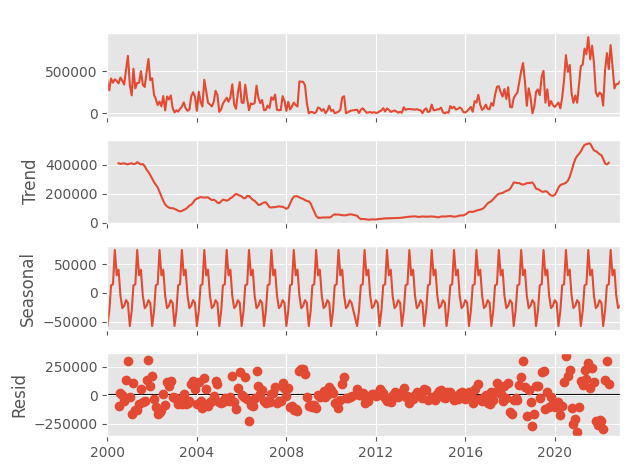

In [ ]:
seasonal_decompose(qty_series["y"], model="additive", period=12).plot()